In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
import numpy as np

Welcome to JupyROOT 6.15/01


In [2]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [3]:
def getLeptonData(inputFiles):
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [4]:
def getJetData(inputFiles):
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')

    scalar.append('e_pt')

    
    #hadron variables
    cols.append('jt')
    cols.append('z')
    cols.append('pid')
    cols.append('pt')
    #cols.append('eta')
    #cols.append('rap')
    #cols.append('theta')
    #cols.append('p')
    
    
    cols.append('in_jet_pt')
    cols.append('in_jet_qt')

    cols.append('in_jet_dphi')
    cols.append('in_jet_eta')
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [5]:
##Selection on event variables
def applyEventCuts(df):
    print '################### ' 
    print 'Applying event selection'
    temp = df
    #temp = applyCut(temp, 'y < 0.95 and y>0.01', '0.01 < y < 0.95')
    #temp = applyCut(temp, 'Q2>50', 'Q2>50')
    
    temp = applyCut(temp, 'y < 0.85 and y>0.1', '0.1 < y < 0.85')
    temp = applyCut(temp, 'Q2>25', 'Q2>25')

    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('logx= log(x)/2.3025850', inplace=True)
    print '################### \n' 
    return temp

In [6]:
def applyJetCuts(df):
    print '################### ' 
    print 'Applying jet selection'
    temp = df
    temp = applyCut(temp, 'abs(pid)==211 or abs(pid)==111 or abs(pid)==321', 'Keep pions and charged kaons')
    temp = applyCut(temp, 'in_jet_pt>5', ' jet pT > 5 GeV') 
    temp = applyCut(temp, 'in_jet_dphi>2.74', ' e-jet dphi > 2.74') 
    temp.eval('in_jet_p = in_jet_pt*cosh(in_jet_eta)', inplace=True)
    temp.eval('in_jet_qtnorm = in_jet_qt/in_jet_pt', inplace=True)
    temp = applyCut(temp, 'in_jet_qtnorm<0.3', ' qt/ptjet< 0.3') 

    print '################### \n' 


    return temp

## Get inclusive data

In [7]:
#df_inclusive = getLeptonData(['CC_10_275.root'])
#df_inclusive = getLeptonData(['NC_10_275.root'])
df_inclusive = getLeptonData(['pytree.root'])

xsec = np.mean(df_inclusive['xsec'])
xsec = xsec*1e9
print 'xsection %2.2f [pb]' %(xsec)
accepted = df_inclusive.shape[0]
print 'accepted events' , accepted
to_cross_section = xsec/(1.0*accepted)
lumi = 100 # in units of fb-1. 
to_counts = to_cross_section*1000*lumi #1000 accounts to pass from pb to fb
##Apply selection
df_inclusive = applyEventCuts(df_inclusive)

##Total cross-section: 
integrated_rate    = 1000*lumi*xsec #multiply by 1000 and then 100 to get integrated yield for 100 fb-1
print 'Integrated rate %2.3f [M]' %(integrated_rate/1e6)




Processed pytree.root in 1.7 seconds
xsection 17676.24 [pb]
accepted events 999997
################### 
Applying event selection
0.1 < y < 0.85 535174  fraction kept: 53.5
Q2>25 531834  fraction kept: 99.4
################### 

Integrated rate 1767.624 [M]


## Get jet/hadron data

In [8]:
#df = getJetData(['CC_10_275.root'])
#df = getJetData(['NC_10_275.root'])
df = getJetData(['pytree.root'])

df = applyEventCuts(df)
df = applyJetCuts(df)



Processed pytree.root in 30.9 seconds
################### 
Applying event selection
0.1 < y < 0.85 1049428  fraction kept: 53.4
Q2>25 1048332  fraction kept: 99.9
################### 

################### 
Applying jet selection
Keep pions and charged kaons 970984  fraction kept: 92.6
 jet pT > 5 GeV 970984  fraction kept: 100.0
 e-jet dphi > 2.74 890945  fraction kept: 91.8
 qt/ptjet< 0.3 728765  fraction kept: 81.8
################### 



In [9]:
df.head(20)


,Q2,pt,evid,jt,in_jet_eta,pid,e_pt,xsec,W2,y,x,z,in_jet_dphi,in_jet_pt,in_jet_qt,__array_index,logQ2,logx,in_jet_p,in_jet_qtnorm
5,180.746933,0.372694,2,0.210791,-0.378283,211.0,8.139565,0.000012,6788.080566,0.633450,0.025940,0.039215,3.031099,7.539340,1.052963,0,2.257071,-1.586034,8.085237,0.139663
6,180.746933,0.579729,2,0.244708,-0.378283,211.0,8.139565,0.000012,6788.080566,0.633450,0.025940,0.065162,3.031099,7.539340,1.052963,1,2.257071,-1.586034,8.085237,0.139663
7,180.746933,3.293679,2,0.136932,-0.378283,-211.0,8.139565,0.000012,6788.080566,0.633450,0.025940,0.430383,3.031099,7.539340,1.052963,2,2.257071,-1.586034,8.085237,0.139663
24,361.977539,0.479991,15,0.378291,0.466623,211.0,12.444303,0.000018,5932.881836,0.572179,0.057512,0.020066,3.117049,13.378807,0.986703,0,2.558682,-1.240244,14.861960,0.073751
26,361.977539,0.228634,15,0.109522,0.466623,-211.0,12.444303,0.000018,5932.881836,0.572179,0.057512,0.013734,3.117049,13.378807,0.986703,2,2.558682,-1.240244,14.861960,0.073751
27,361.977539,0.147439,15,0.143815,0.466623,-211.0,12.444303,0.000018,5932.881836,0.572179,0.057512,0.015502,3.117049,13.378807,0.986703,3,2.558682,-1.240244,14.861960,0.073751
28,361.977539,0.840717,15,0.267144,0.466623,211.0,12.444303,0.000018,5932.881836,0.572179,0.057512,0.054944,3.117049,13.378807,0.986703,4,2.558682,-1.240244,14.861960,0.073751
29,361.977539,3.945043,15,1.507738,0.466623,211.0,12.444303,0.000018,5932.881836,0.572179,0.057512,0.298124,3.117049,13.378807,0.986703,5,2.558682,-1.240244,14.861960,0.073751
30,34.937485,0.588303,16,0.588226,0.572859,-211.0,5.335162,0.000018,2004.116821,0.185289,0.017142,0.163535,2.984256,5.209832,0.838066,0,1.543292,-1.765950,6.088314,0.160862
31,34.937485,0.482125,16,0.264204,0.572859,-211.0,5.335162,0.000018,2004.116821,0.185289,0.017142,0.083048,2.984256,5.209832,0.838066,1,1.543292,-1.765950,6.088314,0.160862


## Plot all variables in the dataframe (after selection)

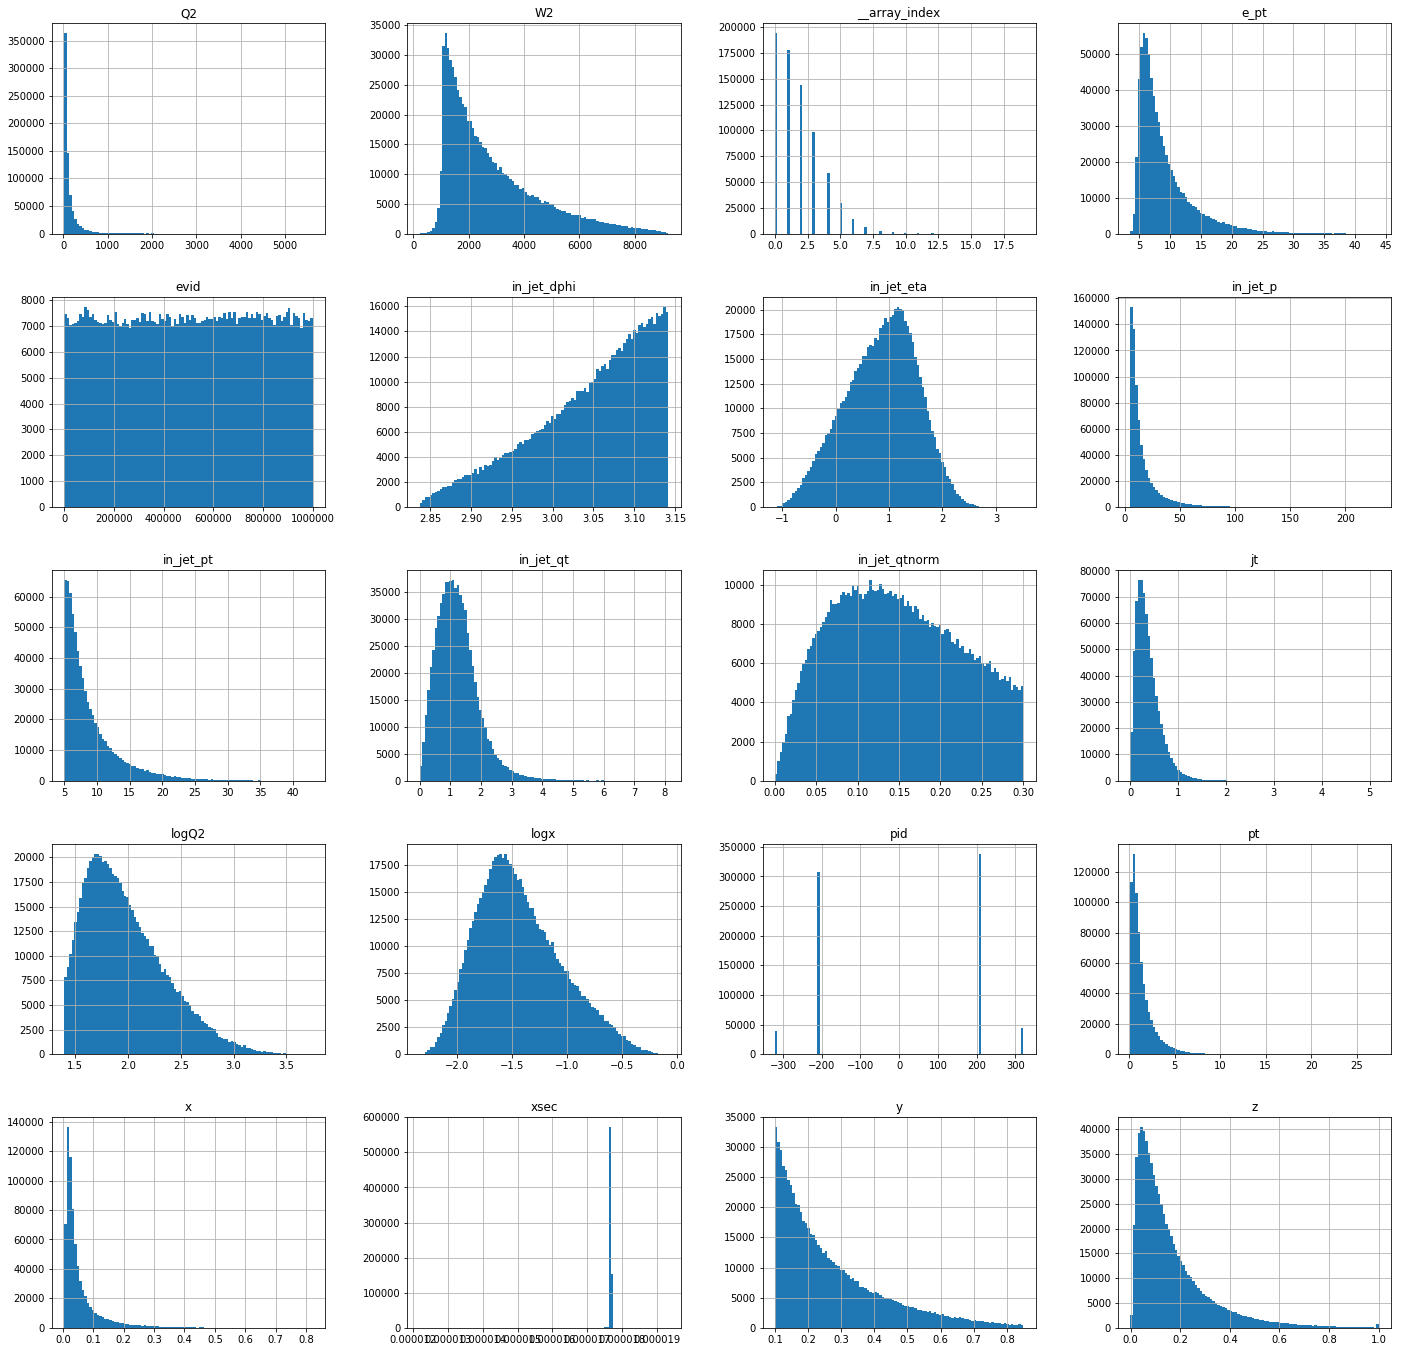

In [10]:
from matplotlib import rc
rc('text', usetex=False)
df.hist(figsize=(24,24),bins=100)
plt.show()

## Labels

In [11]:
jT_str = r'$j_T = |\vec{p}_{\mathrm{jet}} \times \vec{p}_{\mathrm{hadron}}| \left/ |\vec{p}_{\mathrm{jet}}| \right GeV$'
z_str = r'$z_{h} = |\vec{p}_{\mathrm{jet}} \cdot \vec{p}_{\mathrm{hadron}}| \left/ |\vec{p}_{\mathrm{jet}}|^2 \right.$'


## Dilution factors

In [12]:
dilution_factor = 0.7 # proton polarization  
efficiency = 0.8 #efficiency
penalty = 1.4 #sqrt(2) coming from separating statistically different azimuthal asymmetries
lumi = 100 # in units of fb-1. 100 is expected in a year running at 10e34. 
JES = 0.03 #jet energy scale uncertainty in percentage. 

## Fake asymmetries (should be updated with proper calculation)

In [13]:
max_A = 0.050
min_A = 0.001
slope = max_A-min_A
def fake_A(x,slope=max_A-min_A):
    return x*slope + min_A

In [14]:
def printSummary(df):
    print df['e_pt'].mean(), ' mean lepton pt'
    print df['y'].mean(), ' mean inelasticity'
    print df['in_jet_p'].mean(), ' mean jet p'
    print df['z'].mean(), ' z'
    print df['jt'].mean(), ' jt'
    print df['in_jet_pt'].mean(), ' mean jet pT'
    print df['in_jet_qt'].mean(), ' mean jet qT'
    print df['in_jet_qtnorm'].mean(), ' mean jet qT / jet pT'

    print df['in_jet_pt'].describe()
    print df['in_jet_qt'].describe()
    print df['in_jet_qtnorm'].describe()
    print df['x'].mean(), ' mean x'
    print df['Q2'].mean(), ' mean Q2'
    print df['Q2'].describe()
    print df['jt'].describe()

    return

## Main result, integrated over x

number of inclusive events  46018462.65568779
17.13651  mean lepton pt
0.2330333  mean inelasticity
46.10131  mean jet p
0.123353235  z
0.4298549  jt
16.599985  mean jet pT
1.594525  mean jet qT
0.10203001  mean jet qT / jet pT
count    105629.000000
mean         16.599985
std           4.553952
min           7.814454
25%          13.221320
50%          15.853780
75%          19.130608
max          38.578068
Name: in_jet_pt, dtype: float64
count    105629.000000
mean          1.594525
std           0.988645
min           0.010627
25%           0.882219
50%           1.400811
75%           2.089484
max           8.106052
Name: in_jet_qt, dtype: float64
count    105629.000000
mean          0.102030
std           0.065130
min           0.000852
25%           0.052304
50%           0.087201
75%           0.137895
max           0.299973
Name: in_jet_qtnorm, dtype: float64
0.18259734  mean x
468.0594  mean Q2
count    105629.000000
mean        468.059387
std         389.659180
min         11

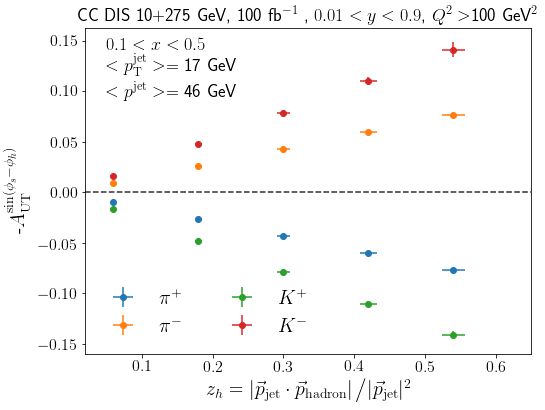

In [15]:
from matplotlib import rc
rc('text', usetex=True)
maxz = 0.6
binsz = 5
fig = plt.figure(figsize=(8,6))
query = 'x>%2.2f and x<=%2.2f '%(0.1,0.5)

print 'number of inclusive events ', df_inclusive.query(query).shape[0]*to_counts

for dataframe in [df]:
    df_cut = dataframe.query(query)
    
    meanQ2 = df_cut['Q2'].mean()
    mean_pt = df_cut['in_jet_pt'].mean()
    mean_p = df_cut['in_jet_p'].mean()
    printSummary(df_cut)
    
    print '###########'
    #positive pion
    print 'positive pions'
    y, x  = np.histogram(df_cut.query('pid==211')['z'],bins=binsz,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=-fake_A(x,0.14) ,yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{+}$')
    
    #negative pion
    print 'negative pions'

    y, x  = np.histogram(df_cut.query('pid==-211')['z'],bins=binsz,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency    
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=+fake_A(x,0.14) ,yerr=erry,xerr=JES*x,fmt='o',ls='none',label='$\pi^{-}$')
    plt.axhline(y=0.0,color='black',linestyle='--',alpha=0.5)

    ##K+
    y, x  = np.histogram(df_cut.query('pid==321')['z'],bins=binsz,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=-fake_A(x,0.26) , yerr=erry,xerr=JES*x,fmt='o',ls='none',label='$K^{+}$')

    ##K-
    y, x  = np.histogram(df_cut.query('pid==-321')['z'],bins=binsz,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=+fake_A(x,0.26) , yerr=erry,xerr=JES*x,fmt='o',ls='none',label='$K^{-}$')
    plt.axhline(y=0.0,color='black',linestyle='--',alpha=0.5)
    
    
####
#plt.ylim([-0.061,0.061])
plt.xlim([0.02,0.65])

plt.text(0.05, 0.095, '$0.1<x<0.5$ \n $<p_{\mathrm{T}}^{\mathrm{jet}}>$' +'= %2.0f GeV \n $<p^{\mathrm{jet}}>$= %2.0f GeV'%(mean_pt,mean_p), fontsize=18)
plt.title('CC DIS 10+275 GeV, 100 fb$^{-1}$ , $0.01<y<0.9$, $Q^{2}>$100 GeV$^{2}$', fontsize=18)
#plt.text(0.05, 0.025, '$<p_{\mathrm{T}}^{\mathrm{jet}}>$=%2.0f GeV'%df_cut['in_jet_pt'].mean() + ' , $5\%$ JES error', fontsize=17)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc='lower left', fontsize=20,frameon=False,ncol=2)
plt.ylabel('-$A_{\mathrm{UT}}^{\sin(\phi_s-\phi_h)}$',fontsize=20)
plt.xlabel(z_str,fontsize=20)
plt.savefig('CC_AUT_main_comparison.png', bbox_inches='tight')
plt.savefig('CC_AUT_main_comparison.pdf', bbox_inches='tight')

0 0
x>0.10 and x<=0.20 and jt<1.0 
15.14077  mean lepton pt
0.23224844  mean inelasticity
36.121452  mean jet p
0.121110715  z
0.36935568  jt
14.6642  mean jet pT
1.5615939  mean jet qT
0.11037827  mean jet qT / jet pT
count    69374.000000
mean        14.664200
std          3.042577
min          7.814454
25%         12.356450
50%         14.320719
75%         16.667877
max         27.907898
Name: in_jet_pt, dtype: float64
count    69374.000000
mean         1.561594
std          0.929620
min          0.010627
25%          0.883362
50%          1.385981
75%          2.064759
max          7.293253
Name: in_jet_qt, dtype: float64
count    69374.000000
mean         0.110378
std          0.066602
min          0.000852
25%          0.059393
50%          0.095981
75%          0.149724
max          0.299859
Name: in_jet_qtnorm, dtype: float64
0.13843876  mean x
353.13  mean Q2
count    69374.000000
mean       353.130005
std        241.831985
min        110.730133
25%        192.761597
50%     

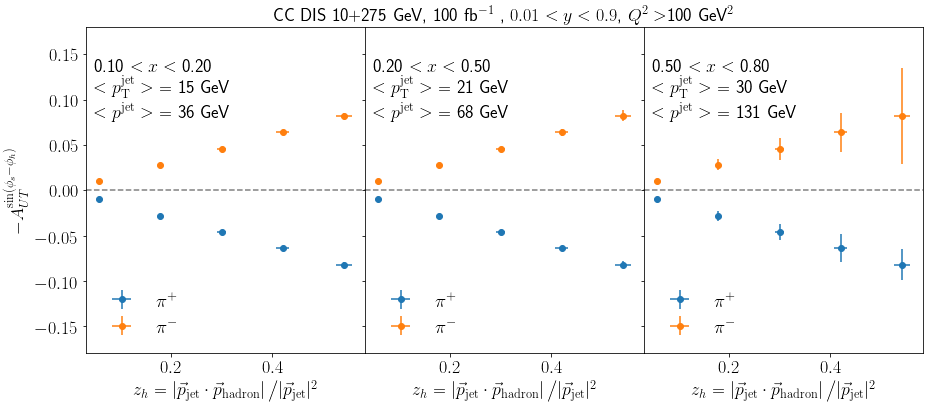

In [16]:
fig, axs = plt.subplots(1, 3,sharex=True,sharey=True, figsize=(15,6), gridspec_kw={'wspace':0, 'hspace':0.0})
Edges = [0.1, 0.2,0.5,0.8]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

maxz = 0.6
axs[1].set_title('CC DIS 10+275 GeV, 100 fb$^{-1}$ , $0.01<y<0.9$, $Q^{2}>$100 GeV$^{2}$', fontsize=18)


for j, ibin in enumerate(bins):
    if j<3:
        i = 0
    else:
        i= 1
        j= j%3
    print i, j
    query = 'x>%2.2f and x<=%2.2f and jt<1.0 '%(ibin[0],ibin[1])
    print query
    df_cut = df.query(query)
    printSummary(df_cut)

    meanQ2 = df_cut['Q2'].mean()
    mean_pt = df_cut['in_jet_pt'].mean()
    mean_p = df_cut['in_jet_p'].mean()
    
    print '#############################################################'
    #pi+
    y, x  = np.histogram(df_cut.query('pid==211')['z'],bins=binsz,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    axs[j].errorbar(x,y=-fake_A(x,0.15) , yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{+}$')
    
    #pi-
    y, x  = np.histogram(df_cut.query('pid==-211')['z'],bins=binsz,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    axs[j].errorbar(x,y=fake_A(x,0.15) , yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{-}$')
    axs[j].tick_params('both',labelsize=18)
    
    axs[j].legend(loc='lower left',fontsize=19,frameon=False)
    axs[j].xaxis.set_label_text(z_str,fontsize=18)
    #axs[i,j].set_title('%2.2f $<x<$ %2.2f, $<Q^{2}>$=%2.0f GeV$^{2}$'%(ibin[0],ibin[1],meanQ2), fontsize=14)    
    axs[j].axhline(y=0.0,color='black',linestyle='--',alpha=0.5)
    axs[j].text(0.05, 0.08, '%2.2f $<x<$ %2.2f\n $<p_{\mathrm{T}}^{\mathrm{jet}}>$ = %2.0f GeV \n $<p^{\mathrm{jet}}>$ = %2.0f GeV'%(ibin[0],ibin[1],df_cut['in_jet_pt'].mean(),df_cut['in_jet_p'].mean()), fontsize=18)
    #axs[i,j].text(0.05, 0.04, '$<p^{\mathrm{jet}}>$ = %2.0f GeV'%df_cut['in_jet_p'].mean(), fontsize=14)

    plt.ylim([-0.18,0.18])
    #plt.yticks(fontsize=28)
    #plt.xticks(fontsize=28)
    
axs[0].yaxis.set_label_text('$-A_{UT}^{\sin(\phi_s-\phi_h)}$',fontsize=18)
#axs[1].yaxis.set_label_text('$A_{UT}^{\sin(\phi_s-\phi_h)}$',fontsize=18)
plt.savefig('CC_AUT_projections_xbins.png', bbox_inches='tight')
plt.savefig('CC_AUT_projections_xbins.pdf', bbox_inches='tight')

In [17]:
n = df_inclusive.query('x>0.1 and x<0.2 and y>0.1 and y<0.85').shape[0]
xsec = n*to_cross_section
print xsec , ' picobarns'
events = n*to_counts
print events , ' events'


339.1727208409531  picobarns
33917272.08409531  events


[0.1        0.17777778 0.25555556 0.33333333 0.41111111 0.48888889
 0.56666667 0.64444444 0.72222222 0.8       ]
15.145958  mean lepton pt
0.2325163  mean inelasticity
35.972168  mean jet p
0.12787715  z
0.39153677  jt
14.67042  mean jet pT
1.5644891  mean jet qT
0.11052196  mean jet qT / jet pT
count    19661.000000
mean        14.670420
std          3.051634
min          7.943754
25%         12.346238
50%         14.310683
75%         16.663074
max         27.907898
Name: in_jet_pt, dtype: float64
count    19661.000000
mean         1.564489
std          0.934946
min          0.017283
25%          0.886136
50%          1.385635
75%          2.063650
max          7.293253
Name: in_jet_qt, dtype: float64
count    19661.000000
mean         0.110522
std          0.066806
min          0.001165
25%          0.059290
50%          0.096241
75%          0.149550
max          0.299859
Name: in_jet_qtnorm, dtype: float64
0.13849175  mean x
353.71445  mean Q2
count    19661.000000
mean       353.

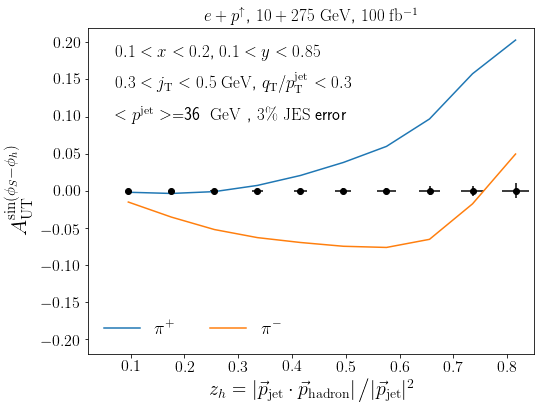

In [18]:



x = np.array([   0.1,
   0.1777778,
   0.2555556,
   0.3333333,
   0.4111111,
   0.4888889,
   0.5666667,
   0.6444444,
   0.7222222,
   0.8])
print np.linspace(0.1,0.8,10)
yCollins = np.array([  -0.002176051,
   -0.003800409,
   -0.001322555,
   0.007040357,
   0.02044658,
   0.03806083,
   0.05969584,
   0.09668781,
   0.1576761,
   0.203112])
yCollins_piminus = np.array([-0.01538482,
   -0.03567332,
   -0.05246434,
   -0.06336871,
   -0.06994237,
   -0.07505112,
   -0.07662682,
   -0.06568882,
   -0.01782082,
   0.04938627])

error_low_pip = np.array([ -0.002228229,
   -0.003918897,
   -0.001555065,
   0.006521372,
   0.01935208,
   0.03598205,
   0.05607464,
   0.08969243,
   0.1437734,
   0.1816968])

error_high_pip = np.array([ -0.001903139,    -0.00304568,   2.867384e-05, 0.009087405, 0.0233281, 0.04197038, 0.06472539, 0.1030856,
                        0.16537,  0.2111522 ])


error_low_piminus = np.array([-0.01561367,  -0.03616754,   -0.05334069,   -0.06462858,  -0.071627,   -0.07727906,   -0.079537,   -0.06975179,
   -0.02502352,   0.03551214,])

error_high_piminus = np.array([ -0.0145321,   -0.03361187,  -0.04893768,   -0.05810266,-0.06250732,  -0.06467461, -0.06249507,-0.04683621,   0.005072042,0.07391493])


from matplotlib import rc
rc('text', usetex=True)
maxz = 0.8
#fig = plt.figure(figsize=(9,4.5))
fig = plt.figure(figsize=(8,6))
jtmin = 0.3
jtmax = 0.5
min_x = 0.1
max_x = 0.2
query = 'x>%2.2f and x<=%2.2f and jt>%2.2f and jt<%2.2f and in_jet_qtnorm<0.3'%(min_x,max_x,jtmin,jtmax)

df_cut = dataframe.query(query)
meanQ2 = df_cut['Q2'].mean()
printSummary(df_cut)


#positive pion
y, x  = np.histogram(df_cut.query('abs(pid)==211')['z'],bins=10,range=(0,maxz))
x = (x[1:]+x[:-1])/2
x = x+0.5/9


y = y*to_counts
print ' YIELD'
print y
y = y*efficiency
erry = penalty*1/(dilution_factor*np.sqrt(y))
print ' ERROR '
print erry*100
print 1/(np.sqrt(y))*100
#print len(x)
#print np.zeros(9)

plt.errorbar(x,y=np.zeros(len(x)), yerr=erry,xerr=JES*x, fmt='o',ls='none',color='black')




plt.plot(x,yCollins, '-', label='$\pi^{+}$')
#plt.fill_between(x, error_low_pip , error_high_pip,alpha=0.5,label='$\pi^{+}$')
#plt.fill_between(x, error_low_piminus , error_high_piminus , alpha=0.5, label='$\pi^{-}$')
plt.plot(x,yCollins_piminus, '-', label='$\pi^{-}$')


##negative pion
#y, x  = np.histogram(df_cut.query('pid==-211')['z'],bins=6,range=(0,maxz))
#x = (x[1:]+x[:-1])/2
#y = y*to_counts
#y = y*efficiency
#erry = penalty*1/(dilution_factor*np.sqrt(y))
#plt.errorbar(x,y=-1.0*yCollins , yerr=erry,xerr=JES*x,fmt='o',ls='none',label='$\pi^{-}$')
#plt.axhline(y=0.0,color='black',linestyle='--',alpha=0.5)


####
plt.ylim([-0.22,0.22])
plt.xlim([0.02,0.85])

plt.title('$e+p^{\uparrow}$, $10+275 \mathrm{ ~GeV}$, $100$ $\mathrm{fb}$^{-1}$', fontsize=17)
plt.text(0.07, 0.180, '$0.1<x<0.2$, $0.1<y<0.85$ ',fontsize=17)
plt.text(0.07, 0.130, '$0.3<j_{\mathrm{T}}<0.5 \mathrm{ ~GeV}$, $q_{\mathrm{T}}/p_{\mathrm{T}}^{\mathrm{jet}}<0.3$' ,fontsize=17)
plt.text(0.07, 0.095, '$<p^{\mathrm{jet}}>$=%2.0f $\mathrm{~GeV}$'%df_cut['in_jet_p'].mean() + ' , $3\%$ $\mathrm{JES}$\mathrm{~error}', fontsize=17)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.axhline(y=0.0,color='black',linestyle='--',alpha=0.5)

#lg= plt.legend(loc='lower left', fontsize=18,frameon=False,ncol=2,title='Arratia, Kang, Prokudin, Ringer (prelim)')
lg= plt.legend(loc='lower left', fontsize=18,frameon=False,ncol=2)

title = lg.get_title()
title.set_fontsize(16)
plt.ylabel('$A_{\mathrm{UT}}^{\sin(\phi_S-\phi_h)}$',fontsize=22)
plt.xlabel(z_str,fontsize=20)



plt.savefig('AUT_main_comparison.png', bbox_inches='tight')
plt.savefig('AUT_main_comparison.pdf', bbox_inches='tight')

In [28]:
## Data Alexei

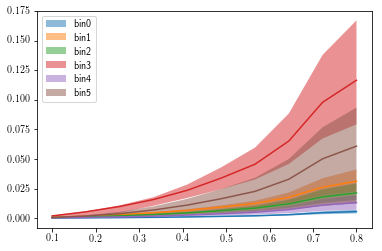

In [59]:
#bin 0
x_theory = np.array([0.1,0.1777778,0.2555556,0.3333333,0.4111111,0.4888889,0.5666667,0.6444444,0.7222222, 0.8])

y_theory = {}
y_theory_err_up = {}
y_theory_err_down = {}

y_theory['bin0'] = np.array([  6.951284e-05, 0.0001995366, 0.0003768006, 0.0006225944, 0.0009613608,
                        0.001417201, 0.001946287, 0.002892542,0.004575915, 0.005529653])

y_theory['bin1'] = np.array([0.0005844243, 0.001623437,0.002894868,0.00447866, 0.00655805,
                             0.009287565, 0.01238977, 0.0175554, 0.0261653, 0.03108781])

y_theory['bin2'] = np.array([ 0.0003740029, 0.001055901,  0.001908806,  0.002991711,   0.004423049,
                               0.006301778,  0.008432871,   0.01199009,   0.01791422,   0.02126765])

y_theory['bin3'] = np.array([0.001841892,  0.00530855,   0.00980083,   0.01567932,   0.02352416,
                           0.03382184,   0.04551345,   0.0651338,   0.09792359,   0.1164755])

y_theory['bin4'] = np.array([ 0.0001698257,   0.0005093087,   0.0009795277,   0.001627423,   0.002505004,
                              0.003656911,   0.004968031,   0.007187476,   0.0109208,   0.01303938])

y_theory['bin5'] = np.array([   0.0005236509,   0.001768595,   0.003787206,   0.006829874,   0.01099876,
                                0.01637615,   0.02257342,   0.03284678, 0.05013319,   0.06079942])

y_theory_err_down['bin0'] = np.array([2.124711e-05,  8.428673e-05, 0.0002138863, 0.0004484016,  0.0007160034, 0.001052176,
                                    0.001439574,  0.002121271,  0.003311444,  0.003958275])

y_theory_err_up['bin0'] =  np.array([0.0001562537, 0.0004111665,0.0006886853,0.0009855924,0.001349611,0.001830029,0.002366909,
                                     0.003458573,0.005712595,0.007076705])

y_theory_err_down['bin1'] =np.array([5.564296e-05, 0.0003823985, 0.001199115,0.002723707,0.004885578,
                                     0.006872151, 0.009124814, 0.01285244,0.01902214, 0.02251006])
 
y_theory_err_up['bin1'] = np.array([ 0.0007176235,    0.001939881,  0.003337544, 0.005118883,  0.007533849, 0.01068213,
                                    0.01467801,  0.02166364, 0.03372252, 0.04109741])

y_theory_err_down['bin2'] = np.array([ 2.690059e-05, 0.0002422935,0.0008090044,0.001876699,0.003254184,
                                      0.004609141, 0.006143354, 0.008690353,0.01290608, 0.01526834])

y_theory_err_up['bin2'] = np.array([ 0.0004070505, 0.001159344,0.002122263,0.003369389, 0.005062941,
                                    0.007597282,0.01052312, 0.01557481, 0.02427109,  0.02939822])
 
    
y_theory_err_down['bin3'] = np.array([0.0001278797,  0.001308605, 0.004467875, 0.01042595, 0.01706603,   0.02443286,
                                       0.03260951,   0.04575279,  0.06731039,  0.07921279])
               
y_theory_err_up['bin3'] = np.array([   0.001953411, 0.005710692,   0.01073905,  0.01770672,  0.02842225,
                                   0.04288646,0.05956717,0.0884028,0.1380008,0.1670792])

y_theory_err_down['bin4'] = np.array([1.875471e-05,  0.000161239,  0.0005301265,  0.001045863,   0.001532518,
                                   0.002170721,  0.002889125,   0.004079412,   0.006039086,   0.007120497])
   
y_theory_err_up['bin4'] = np.array([0.0001801629,   0.0005555168,   0.001100983, 0.001987951,   0.003278272,
                                    0.004973563, 0.00692579,   0.01030339,0.01610485,    0.01948364]) 
    
y_theory_err_down['bin5'] = np.array([ 0.0001925196,   0.0005657098,   0.001060579,   0.001715551,   0.002584377,
                                       0.003705645,    0.004982741,   0.007055132,   0.01047128,   0.01252903])

y_theory_err_up['bin5']  = np.array([   0.0006510255, 0.0023518,0.005309112,0.009931524,  0.01631704,
                                         0.02455312, 0.03407267,0.04993514,   0.07675537,  0.09339535])



plt.plot(x_theory,y_theory['bin0'], '-')
plt.fill_between(x_theory, y_theory_err_down['bin0'] , y_theory_err_up['bin0'],alpha=0.5,label='bin0')                   

    
plt.plot(x_theory,y_theory['bin1'], '-')
plt.fill_between(x_theory, y_theory_err_down['bin1'] , y_theory_err_up['bin1'],alpha=0.5,label='bin1')  

plt.plot(x_theory,y_theory['bin2'], '-')
plt.fill_between(x_theory, y_theory_err_down['bin2'] , y_theory_err_up['bin2'],alpha=0.5,label='bin2')   

plt.plot(x_theory,y_theory['bin3'], '-')
plt.fill_between(x_theory, y_theory_err_down['bin3'] , y_theory_err_up['bin3'],alpha=0.5,label='bin3')  

plt.plot(x_theory,y_theory['bin4'], '-')
plt.fill_between(x_theory, y_theory_err_down['bin4'] , y_theory_err_up['bin4'],alpha=0.5,label='bin4')  

plt.plot(x_theory,y_theory['bin5'], '-')
plt.fill_between(x_theory, y_theory_err_down['bin5'] , y_theory_err_up['bin5'],alpha=0.5,label='bin5')  

#0.007076705,
#   0.005712595,
#   0.003458573,
#   0.002366909,
#   0.001830029,
#   0.001349611,
#   0.0009855924,
#   0.0006886853,
#   0.0004111665,
#   0.0001562537,
#   2.124711e-0
plt.legend()       
                   
    

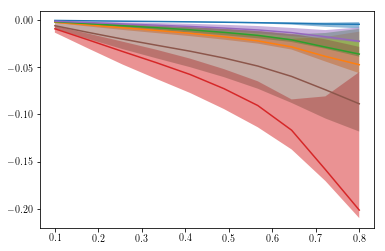

In [83]:
## PI-
x_theory = np.array([0.1,0.1777778,0.2555556,0.3333333,0.4111111,0.4888889,0.5666667,0.6444444,0.7222222, 0.8])
y_pim_theory = {}
y_pim_theory_err_up = {}
y_pim_theory_err_down = {}

y_pim_theory['bin0'] = np.array([ -0.0002653725,
   -0.0006436872,
   -0.001025331,
   -0.001375627,
   -0.001733394,
   -0.002167434,
   -0.002647949,
   -0.003275734,
   -0.004022616,
   -0.004328592])
y_pim_theory_err_down['bin0'] = np.array([ -0.0003448647,   -0.000827446,   -0.001292771,   -0.001695112,   -0.00208265,
                                         -0.002645569,   -0.003433303,   -0.004725107,   -0.006999761,   -0.008647647])
 
y_pim_theory_err_up['bin0'] = np.array([      -0.0001945608,     -0.0004733856,   -0.0007597309,-0.00102919,   -0.001294598,
                                     -0.001616526,  -0.001972392,   -0.002440051,   -0.00250317,  -0.001997991])


y_pim_theory['bin1'] = np.array([ -0.0021572,
   -0.005044879,
   -0.007970023,
   -0.01082628,
   -0.01387919,
   -0.01758272,
   -0.02193539,
   -0.02832803,
   -0.03840021,
   -0.04721732])

y_pim_theory_err_down['bin1'] = np.array([  -0.002900771,   -0.006686797,   -0.01033207,   -0.01364323,
                                          -0.01688117,   -0.02063237,   -0.02481687,   -0.03115069,
                                             -0.04383454,   -0.05617568])

y_pim_theory_err_up['bin1'] = np.array([  -0.001570073,   -0.003657787,  -0.005773632,   -0.007859372,   -0.01011541,
                                          -0.01286854,    -0.01612289,-0.01980674,   -0.01776812,   -0.01216564])


y_pim_theory['bin2'] = np.array([ -0.001588893,
   -0.003692145,
   -0.005829176,
   -0.007930841,
   -0.01017286,
   -0.01287775,
   -0.01608858,
   -0.02083199,
   -0.02848997,
   -0.03593401])

y_pim_theory_err_down['bin2'] = np.array([-0.002220495,   -0.005112276,   -0.007942042,   -0.01051456,   -0.01302841,
                                            -0.01591834,   -0.01917329,   -0.02315127,   -0.03031426,   -0.03867826])
  
y_pim_theory_err_up['bin2'] =   np.array([-0.001146874,   -0.002653993,   -0.004184295,   -0.00570025,   -0.007333479,
                                             -0.009314069,   -0.01167642,   -0.01504591,   -0.01354458,    -0.009122973])

y_pim_theory['bin3'] = np.array([-0.009104436,
   -0.02105091,
   -0.03316741,
   -0.04504767,
   -0.05760579,
   -0.07263792,
   -0.09052144,
   -0.116675,
   -0.1585023,
   -0.201433])

y_pim_theory_err_down['bin3'] = np.array([  -0.01318612,   -0.0302416,   -0.04697436,   -0.06227085,   -0.07719297,
                                            -0.09424829,   -0.113562,   -0.137085,   -0.1705777,   -0.209904])
y_pim_theory_err_up['bin3'] = np.array([   -0.006155211,   -0.01430332,   -0.02273116,   -0.03131617,   -0.04075223,
                                           -0.05188725,   -0.06479181,   -0.08401091,   -0.08080855,   -0.05506142])

y_pim_theory['bin4'] = np.array([-0.001073891,   -0.002466943,   -0.00387355,   -0.005241006,   -0.006662167,
                                -0.008340524,   -0.01033542,   -0.01317883,   -0.01754309,   -0.02226562])


y_pim_theory_err_down['bin4'] = np.array([-0.001616035,   -0.003690193,   -0.005733455, -0.007617911,   -0.009457741,
                                            -0.01154947,   -0.01393856,   -0.01685999,   -0.01973392,  -0.02365116])

y_pim_theory_err_up['bin4'] = np.array([   -0.0005823845, -0.001345704,   -0.002134542,   -0.002937523,   -0.003814058,
                                           -0.004877936,   -0.006176859,   -0.008199636,   -0.01045639,   -0.007714761])

y_pim_theory['bin5'] = np.array([-0.005838713,   -0.01303366,   -0.02001526,   -0.02650375,   -0.03289751,
                                   -0.04012773,   -0.04864631,   -0.05964749,   -0.07381485,   -0.08866716])
y_pim_theory_err_down['bin5'] = np.array([ -0.00898064,   -0.02001801,   -0.03065923,   -0.04040981,   -0.049849,
                                             -0.06039902,   -0.07267358,   -0.08776441,   -0.1042838,   -0.1181327])
y_pim_theory_err_up['bin5'] = np.array([    -0.001193892,   -0.002682841,   -0.004166754,   -0.005623489,   -0.007152919,
                                           -0.008951301,   -0.01115627,   -0.0144249,   -0.02024634,   -0.02826819])

    

plt.plot(x_theory,y_pim_theory['bin0'], '-')
plt.fill_between(x_theory, y_pim_theory_err_down['bin0'] , y_pim_theory_err_up['bin0'],alpha=0.5,label='bin0')  

plt.plot(x_theory,y_pim_theory['bin1'], '-')
plt.fill_between(x_theory, y_pim_theory_err_down['bin1'] , y_pim_theory_err_up['bin1'],alpha=0.5,label='bin1')  

plt.plot(x_theory,y_pim_theory['bin2'], '-')
plt.fill_between(x_theory, y_pim_theory_err_down['bin2'] , y_pim_theory_err_up['bin2'],alpha=0.5,label='bin2')  

plt.plot(x_theory,y_pim_theory['bin3'], '-')
plt.fill_between(x_theory, y_pim_theory_err_down['bin3'] , y_pim_theory_err_up['bin3'],alpha=0.5,label='bin3') 

plt.plot(x_theory,y_pim_theory['bin4'], '-')
plt.fill_between(x_theory, y_pim_theory_err_down['bin4'] , y_pim_theory_err_up['bin4'],alpha=0.5,label='bin4') 

plt.plot(x_theory,y_pim_theory['bin5'], '-')
plt.fill_between(x_theory, y_pim_theory_err_down['bin5'] , y_pim_theory_err_up['bin5'],alpha=0.5,label='bin5') 

## Version with stats of data vs theory 

0 0
x>0.01 and x<=0.05 
mean jet pt  6.9552383
mean jet p  9.83013
0 1
x>0.05 and x<=0.10 
mean jet pt  10.516396
mean jet p  20.34688
0 2
x>0.10 and x<=0.15 
mean jet pt  13.838171
mean jet p  32.222866
1 0
x>0.15 and x<=0.20 
mean jet pt  16.40939
mean jet p  44.192673
1 1
x>0.20 and x<=0.30 
mean jet pt  19.441122
mean jet p  59.76569
1 2
x>0.30 and x<=0.80 
mean jet pt  24.716536
mean jet p  92.22967


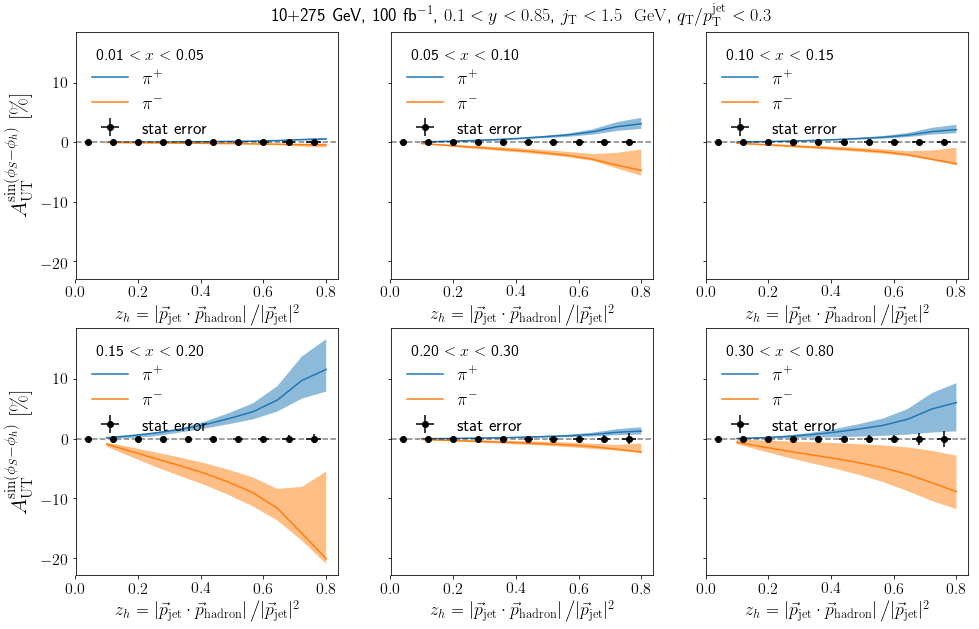

In [84]:
fig, axs = plt.subplots(2, 3,sharex=False,sharey=True, figsize=(16,10))#, gridspec_kw={'wspace':0, 'hspace':0.0})
Edges = [0.01,0.05,0.1, 0.15,0.2,0.3,0.8]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

maxz = 0.8
axs[0,1].set_title('10+275 GeV, 100 fb$^{-1}$, $0.1<y<0.85$, $j_{\mathrm{T}}<1.5$ $\mathrm{ ~GeV}$, $q_{\mathrm{T}}/p_{\mathrm{T}}^{\mathrm{jet}}<0.3$',fontsize=18)

for j, ibin in enumerate(bins):
    counter = j
    if counter>5: continue
    if j<3:
        i = 0
    else:
        i= 1
        j= j%3
    print i, j
    query = 'x>%2.2f and x<=%2.2f '%(ibin[0],ibin[1])
    print query
    df_cut = dataframe.query(query)
    meanQ2 = df_cut['Q2'].mean()
    print 'mean jet pt ', df_cut['in_jet_pt'].mean()
    print 'mean jet p ', df_cut['in_jet_p'].mean()

    #pi+
    y, x  = np.histogram(df_cut.query('abs(pid)==211')['z'],bins=10,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    axs[i,j].errorbar(x,y=np.zeros(len(x)), yerr=100.0*erry,xerr=JES*x, color='k',fmt='o',ls='none',label='stat error')

        
    ## Plot theory
    
    axs[i,j].plot(x_theory,100.0*y_theory['bin%i'%counter], '-', label='$\pi^{+}$')
    axs[i,j].fill_between(x_theory, 100.0*y_theory_err_down['bin%i'%counter] , 100.0*y_theory_err_up['bin%i'%counter],alpha=0.5)                   
       
    axs[i,j].plot(x_theory,100.0*y_pim_theory['bin%i'%counter], '-', label='$\pi^{-}$')
    axs[i,j].fill_between(x_theory, 100.0*y_pim_theory_err_down['bin%i'%counter] , 100.0*y_pim_theory_err_up['bin%i'%counter],alpha=0.5)                   
       
    
#    axs[i,j].legend(loc='best',fontsize=15,frameon=False)
    
    
    lg= axs[i,j].legend(loc='upper left', fontsize=18,frameon=False,title='%2.2f $<x<$ %2.2f'%(ibin[0],ibin[1]))
    title = lg.get_title()
    title.set_fontsize(16)
    
    
    axs[i,j].xaxis.set_label_text(z_str,fontsize=18)
    #axs[i,j].set_title('%2.2f $<x<$ %2.2f, $<Q^{2}>$=%2.0f GeV$^{2}$'%(ibin[0],ibin[1],meanQ2), fontsize=14)    
    axs[i,j].axhline(y=0.0,color='black',linestyle='--',alpha=0.5)
    #axs[i,j].text(0.05, 0.04, '%2.2f $<x<$ %2.2f\n $<p_{\mathrm{T}}^{\mathrm{jet}}>$ = %2.0f GeV \n $<p^{\mathrm{jet}}>$ = %2.0f GeV'%(ibin[0],ibin[1],df_cut['in_jet_pt'].mean(),df_cut['in_jet_p'].mean()), fontsize=14)
    #axs[i,j].text(0.05, 0.04, '$<p^{\mathrm{jet}}>$ = %2.0f GeV'%df_cut['in_jet_p'].mean(), fontsize=14)
    axs[i,j].tick_params('both',labelsize=16)
    #plt.yticks(fontsize=16)
    #plt.xticks(fontsize=16)
    
    
axs[0,0].yaxis.set_label_text('$A_{\mathrm{UT}}^{\sin(\phi_S-\phi_h)}$ $[\%]$',fontsize=22)
axs[1,0].yaxis.set_label_text('$A_{\mathrm{UT}}^{\sin(\phi_S-\phi_h)}$ $[\%]$',fontsize=22)
plt.savefig('AUT_projections_xbins.png', bbox_inches='tight')
plt.savefig('AUT_projections_xbins.pdf', bbox_inches='tight')

x>0.05 and x<=0.10 
x>0.15 and x<=0.20 
x>0.30 and x<=0.80 
[0.05 0.13 0.21 0.29 0.37 0.45 0.53 0.61 0.69 0.77 0.85]


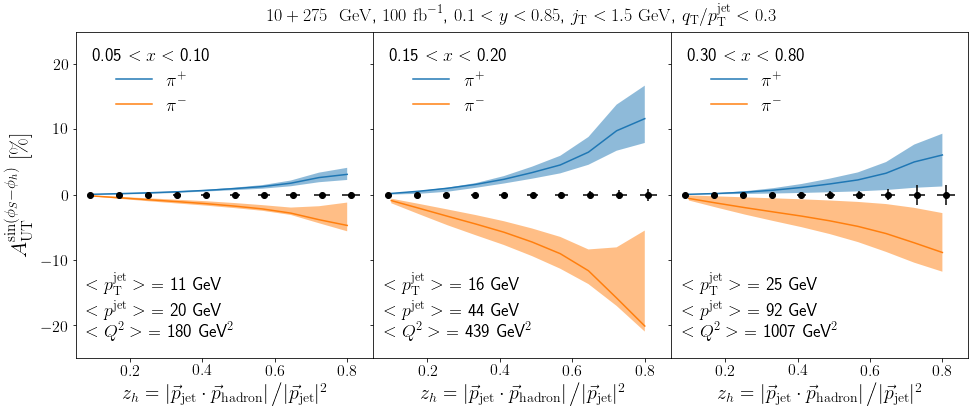

In [135]:
fig, axs = plt.subplots(1, 3,sharex=False,sharey=True, figsize=(16,6),gridspec_kw={'wspace':0, 'hspace':0.0})
Edges = [0.01,0.05,0.1, 0.15,0.2,0.3,0.8]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

maxz = 0.8
axs[1].set_title('$10+275$ $\mathrm{ ~GeV}$, $100$ $\mathrm{fb}^{-1}$, $0.1<y<0.85$, $j_{\mathrm{T}}<1.5\mathrm{~GeV}$, $q_{\mathrm{T}}/p_{\mathrm{T}}^{\mathrm{jet}}<0.3$',fontsize=18)

axs[0].plot(x_theory,100.0*y_theory['bin1'], '-', label='$\pi^{+}$')
axs[0].fill_between(x_theory, 100.0*y_theory_err_down['bin1'] , 100.0*y_theory_err_up['bin1'],alpha=0.5)                   
axs[0].plot(x_theory,100.0*y_pim_theory['bin1'], '-', label='$\pi^{-}$')
axs[0].fill_between(x_theory, 100.0*y_pim_theory_err_down['bin1'] , 100.0*y_pim_theory_err_up['bin1'],alpha=0.5)                       

axs[1].plot(x_theory,100.0*y_theory['bin3'], '-', label='$\pi^{+}$')
axs[1].fill_between(x_theory, 100.0*y_theory_err_down['bin3'] , 100.0*y_theory_err_up['bin3'],alpha=0.5)                   
axs[1].plot(x_theory,100.0*y_pim_theory['bin3'], '-', label='$\pi^{-}$')
axs[1].fill_between(x_theory, 100.0*y_pim_theory_err_down['bin3'] , 100.0*y_pim_theory_err_up['bin3'],alpha=0.5)      

axs[2].plot(x_theory,100.0*y_theory['bin5'], '-', label='$\pi^{+}$')
axs[2].fill_between(x_theory, 100.0*y_theory_err_down['bin5'] , 100.0*y_theory_err_up['bin5'],alpha=0.5)                   
axs[2].plot(x_theory,100.0*y_pim_theory['bin5'], '-', label='$\pi^{-}$')
axs[2].fill_between(x_theory, 100.0*y_pim_theory_err_down['bin5'] , 100.0*y_pim_theory_err_up['bin5'],alpha=0.5)   


axs[0].tick_params('both',labelsize=16)
axs[1].tick_params('both',labelsize=16)
axs[2].tick_params('both',labelsize=16)



query = 'x>%2.2f and x<=%2.2f '%(0.05,0.1)
print query
df_cut = dataframe.query(query)
y, x  = np.histogram(df_cut.query('abs(pid)==211')['z'],bins=10,range=(0.05,maxz+0.05))
x = (x[1:]+x[:-1])/2
y = y*to_counts
y = y*efficiency
erry = penalty*1/(dilution_factor*np.sqrt(y))
axs[0].errorbar(x,y=np.zeros(len(x)), yerr=100.0*erry,xerr=JES*x, color='k',fmt='o',ls='none')


lg= axs[0].legend(loc='upper left', fontsize=18,frameon=False,title='%2.2f $<x<$ %2.2f'%(0.05,0.1))
title = lg.get_title()
title.set_fontsize(18)
axs[0].text(0.08, -22, '$<p_{\mathrm{T}}^{\mathrm{jet}}>$ = %2.0f GeV \n $<p^{\mathrm{jet}}>$ = %2.0f GeV \n  $<Q^{2}>$ = %2.0f GeV$^{2}$'%(df_cut['in_jet_pt'].mean(),df_cut['in_jet_p'].mean(), df_cut['Q2'].mean()), fontsize=18)
    

query = 'x>%2.2f and x<=%2.2f '%(0.15,0.20)
print query
df_cut = dataframe.query(query)
y, x  = np.histogram(df_cut.query('abs(pid)==211')['z'],bins=10,range=(0.05,maxz+0.05))
x = (x[1:]+x[:-1])/2.0
y = y*to_counts
y = y*efficiency
erry = penalty*1/(dilution_factor*np.sqrt(y))
axs[1].errorbar(x,y=np.zeros(len(x)), yerr=100.0*erry,xerr=JES*x, color='k',fmt='o',ls='none')        


lg= axs[1].legend(loc='upper left', fontsize=18,frameon=False,title='%2.2f $<x<$ %2.2f'%(0.15,0.20))
title = lg.get_title()
title.set_fontsize(18)
axs[1].text(0.08, -22, '$<p_{\mathrm{T}}^{\mathrm{jet}}>$ = %2.0f GeV \n $<p^{\mathrm{jet}}>$ = %2.0f GeV \n  $<Q^{2}>$ = %2.0f GeV$^{2}$'%(df_cut['in_jet_pt'].mean(),df_cut['in_jet_p'].mean(), df_cut['Q2'].mean()), fontsize=18)
    

query = 'x>%2.2f and x<=%2.2f '%(0.3,0.80)
print query
df_cut = dataframe.query(query)
y, x  = np.histogram(df_cut.query('abs(pid)==211')['z'],bins=10,range=(0.05,maxz+0.05))
print x
x = (x[1:]+x[:-1])/2

y = y*to_counts
y = y*efficiency
erry = penalty*1/(dilution_factor*np.sqrt(y))
axs[2].errorbar(x,y=np.zeros(len(x)), yerr=100.0*erry,xerr=JES*x, color='k',fmt='o',ls='none') 

lg= axs[2].legend(loc='upper left', fontsize=18,frameon=False,title='%2.2f $<x<$ %2.2f'%(0.3,0.80))
title = lg.get_title()
title.set_fontsize(18)
    

axs[2].text(0.08, -22, '$<p_{\mathrm{T}}^{\mathrm{jet}}>$ = %2.0f GeV \n $<p^{\mathrm{jet}}>$ = %2.0f GeV \n  $<Q^{2}>$ = %2.0f GeV$^{2}$'%(df_cut['in_jet_pt'].mean(),df_cut['in_jet_p'].mean(), df_cut['Q2'].mean()), fontsize=18)

#%%%%%%%



axs[0].yaxis.set_label_text('$A_{\mathrm{UT}}^{\sin(\phi_S-\phi_h)}$ $[\%]$',fontsize=22)
axs[0].xaxis.set_label_text(z_str,fontsize=20)
axs[1].xaxis.set_label_text(z_str,fontsize=20)
axs[2].xaxis.set_label_text(z_str,fontsize=20)




plt.ylim([-25,25])
plt.savefig('AUT_projections_xbins_3bins.png', bbox_inches='tight')
plt.savefig('AUT_projections_xbins_3bins.pdf', bbox_inches='tight')

In [117]:
print x_theory
print x
p =  np.linspace(0.1,0.8,10)
print p
p = p - .70/18
print p

[0.1       0.1777778 0.2555556 0.3333333 0.4111111 0.4888889 0.5666667
 0.6444444 0.7222222 0.8      ]
[0.09       0.16999999 0.25       0.32999998 0.41       0.48999998
 0.57       0.65       0.73       0.81      ]
[0.1        0.17777778 0.25555556 0.33333333 0.41111111 0.48888889
 0.56666667 0.64444444 0.72222222 0.8       ]
[0.06111111 0.13888889 0.21666667 0.29444444 0.37222222 0.45
 0.52777778 0.60555556 0.68333333 0.76111111]


0 0
x>0.01 and x<=0.05 
mean jet pt  6.9552383
mean jet p  9.83013
0 1
x>0.05 and x<=0.10 
mean jet pt  10.516396
mean jet p  20.34688
0 2
x>0.10 and x<=0.15 
mean jet pt  13.838171
mean jet p  32.222866
1 0
x>0.15 and x<=0.20 
mean jet pt  16.40939
mean jet p  44.192673
1 1
x>0.20 and x<=0.30 
mean jet pt  19.441122
mean jet p  59.76569
1 2
x>0.30 and x<=0.80 
mean jet pt  24.716536
mean jet p  92.22967


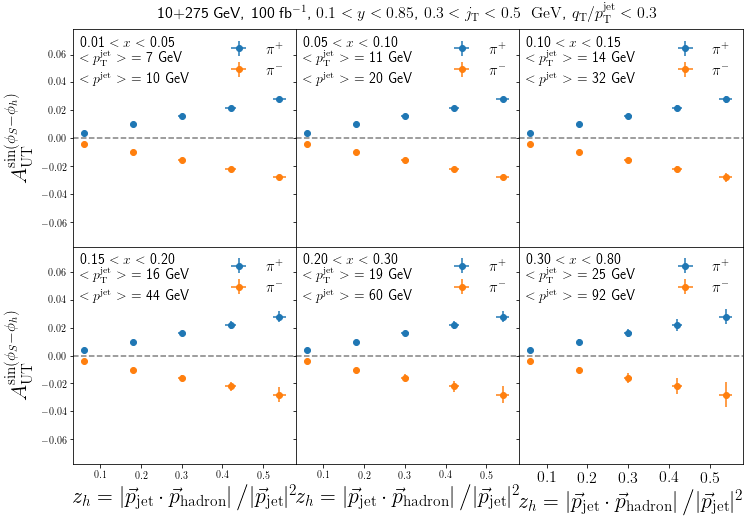

In [27]:
fig, axs = plt.subplots(2, 3,sharex=True,sharey=True, figsize=(12,8), gridspec_kw={'wspace':0, 'hspace':0.0})
Edges = [0.01,0.05,0.1, 0.15,0.2,0.3,0.8]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

maxz = 0.6
axs[0,1].set_title('10+275 GeV, 100 fb$^{-1}$, $0.1<y<0.85$, $0.3<j_{\mathrm{T}}<0.5$ $\mathrm{ ~GeV}$, $q_{\mathrm{T}}/p_{\mathrm{T}}^{\mathrm{jet}}<0.3$',fontsize=16)

for j, ibin in enumerate(bins):
    if j<3:
        i = 0
    else:
        i= 1
        j= j%3
    print i, j
    query = 'x>%2.2f and x<=%2.2f '%(ibin[0],ibin[1])
    print query
    df_cut = dataframe.query(query)
    meanQ2 = df_cut['Q2'].mean()
    print 'mean jet pt ', df_cut['in_jet_pt'].mean()
    print 'mean jet p ', df_cut['in_jet_p'].mean()

    #pi+
    y, x  = np.histogram(df_cut.query('pid==211')['z'],bins=5,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    axs[i,j].errorbar(x,y=fake_A(x,0.05) , yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{+}$')
    
    #pi-
    y, x  = np.histogram(df_cut.query('pid==-211')['z'],bins=5,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    axs[i,j].errorbar(x,y=-fake_A(x,0.05) , yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{-}$')
        
    axs[i,j].legend(loc='best',fontsize=15,frameon=False)
    axs[i,j].xaxis.set_label_text(z_str,fontsize=20)
    #axs[i,j].set_title('%2.2f $<x<$ %2.2f, $<Q^{2}>$=%2.0f GeV$^{2}$'%(ibin[0],ibin[1],meanQ2), fontsize=14)    
    axs[i,j].axhline(y=0.0,color='black',linestyle='--',alpha=0.5)
    axs[i,j].text(0.05, 0.04, '%2.2f $<x<$ %2.2f\n $<p_{\mathrm{T}}^{\mathrm{jet}}>$ = %2.0f GeV \n $<p^{\mathrm{jet}}>$ = %2.0f GeV'%(ibin[0],ibin[1],df_cut['in_jet_pt'].mean(),df_cut['in_jet_p'].mean()), fontsize=14)
    #axs[i,j].text(0.05, 0.04, '$<p^{\mathrm{jet}}>$ = %2.0f GeV'%df_cut['in_jet_p'].mean(), fontsize=14)

    
    
    
    plt.ylim([-0.078,0.078])
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
axs[0,0].yaxis.set_label_text('$A_{\mathrm{UT}}^{\sin(\phi_S-\phi_h)}$',fontsize=22)
axs[1,0].yaxis.set_label_text('$A_{\mathrm{UT}}^{\sin(\phi_S-\phi_h)}$',fontsize=22)
plt.savefig('AUT_projections_xbins_3bins.png', bbox_inches='tight')
plt.savefig('AUT_projections_xbins_3bins.pdf', bbox_inches='tight')

In [19]:
# crosscheck of the yield of hadrons

29353253.08674623
SUMATORIA 3.9442370227628567
[0.05       0.15       0.25       0.35000002 0.45       0.55
 0.65       0.75       0.85       0.95      ]
SUMATORIA 1.062688184993376


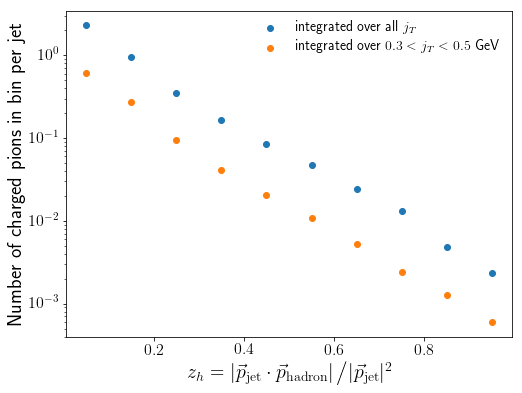

In [20]:
fig = plt.figure(figsize=(8,6))


query = 'x>0.1 and x<0.2 and y<0.85 and y>0.1 and in_jet_qtnorm<0.3'
njets =  len(dataframe.query(query).groupby('in_jet_pt').nunique())
njets = njets*to_counts
print njets

y,x  = np.histogram(dataframe.query(query + 'and abs(pid)==211')['z'],bins=10,range=(0,1.0))
x = (x[1:]+x[:-1])/2
y = y*to_counts
y = y/njets
#y = y*efficiency
print 'SUMATORIA', sum(y)
plt.plot(x,y,'o', label='integrated over all $j_T$')



y,x  = np.histogram(dataframe.query(query + 'and abs(pid)==211 and jt>0.3 and jt<0.5')['z'],bins=10,range=(0,1.0))

x = (x[1:]+x[:-1])/2
print x
y = y*to_counts
y = y/njets
print 'SUMATORIA', sum(y)

#y = y*efficiency
plt.plot(x,y,'o', label='integrated over $0.3<j_T<0.5$ GeV')

plt.legend(loc='best',fontsize=14,frameon=False)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.yscale('log')
plt.ylabel('Number of charged pions in  bin per jet',fontsize=20)
plt.xlabel(z_str,fontsize=20)
plt.show()

56429799.562886104
3.6867873700037594


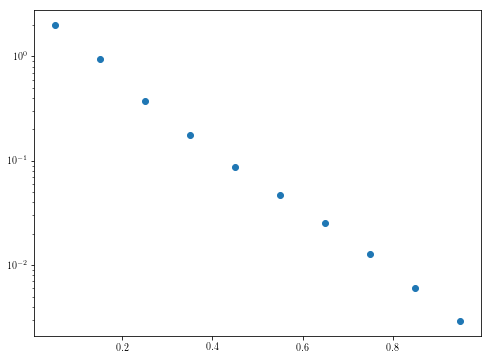

In [21]:
njets =  len(dataframe.query('in_jet_pt>10 and in_jet_pt<15 and y<0.85 and y>0.1 and  in_jet_qtnorm<0.3').groupby('in_jet_pt').nunique())
njets = njets*to_counts
print njets


fig = plt.figure(figsize=(8,6))

y,x  = np.histogram(dataframe.query('in_jet_pt>10 and in_jet_pt<15 and y<0.85 and y>0.1 and  in_jet_qtnorm<0.3 and abs(pid)==211')['z'],bins=10,range=(0,1.0))
x = (x[1:]+x[:-1])/2
y = y*to_counts
y = y/njets
#y = y*efficiency
print sum(y)
plt.plot(x,y,'o', label='integrated over all $j_T$')
plt.yscale('log')
plt.show()

In [22]:
f = len(dataframe.query('in_jet_pt>10 and in_jet_pt<15 and y<0.85 and y>0.1 and in_jet_qtnorm<0.3').groupby('in_jet_pt').nunique())
f = f*to_counts
print f

56429799.562886104


37.610755098769054


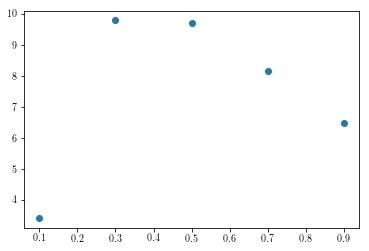

In [23]:
y,x  = np.histogram(dataframe.query('x>0.0 and x<0.05 and y<0.85 and y>0.1 and in_jet_qtnorm<0.3 and abs(pid)==211')['pt'],bins=5,range=(0,1))
x = (x[1:]+x[:-1])/2
y = y*to_counts
y = y/11539084
#y = y*efficiency
print sum(y)
plt.plot(x,y,'o', label='pions integrated over all $j_T$')

0 0
x>0.01 and x<=0.05 


KeyError: '100'

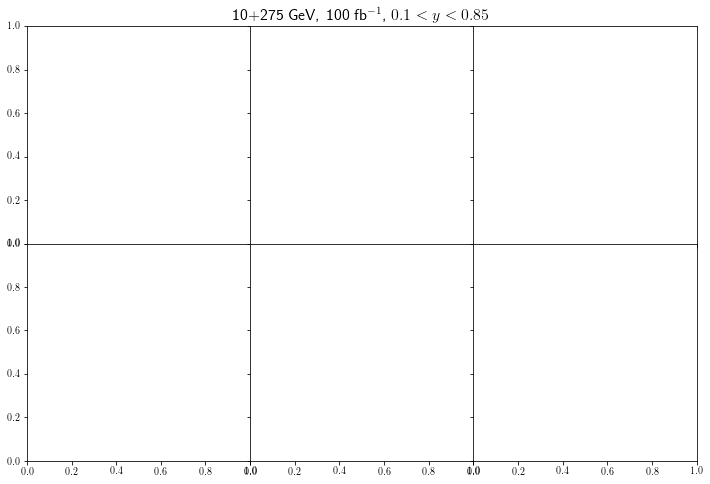

In [24]:
fig, axs = plt.subplots(2, 3,sharex=True,sharey=True, figsize=(12,8), gridspec_kw={'wspace':0, 'hspace':0.0})
Edges = [0.01,0.05,0.1, 0.15,0.2,0.3,0.8]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

maxz = 0.6
axs[0,1].set_title('10+275 GeV, 100 fb$^{-1}$, $0.1<y<0.85$',fontsize=16)

for j, ibin in enumerate(bins):
    if j<3:
        i = 0
    else:
        i= 1
        j= j%3
    print i, j
    query = 'x>%2.2f and x<=%2.2f '%(ibin[0],ibin[1])
    print query
    df_cut = df['100'].query(query)
    meanQ2 = df_cut['Q2'].mean()
    print 'mean jet pt ', df_cut['in_jet_pt'].mean()
    print 'mean jet p ', df_cut['in_jet_p'].mean()

    #pi+
    y, x  = np.histogram(df_cut.query('pid==211')['z'],bins=5,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec['100']*1e12/ntrials['100']
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    axs[i,j].errorbar(x,y=fake_A(x,0.05) , yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{+}$')
    
    #pi-
    y, x  = np.histogram(df_cut.query('pid==-211')['z'],bins=5,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*lumi*xsec['100']*1e12/ntrials['100']
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    axs[i,j].errorbar(x,y=-fake_A(x,0.05) , yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{-}$')
        
    axs[i,j].legend(loc='best',fontsize=15,frameon=False)
    axs[i,j].xaxis.set_label_text(z_str,fontsize=15)
    #axs[i,j].set_title('%2.2f $<x<$ %2.2f, $<Q^{2}>$=%2.0f GeV$^{2}$'%(ibin[0],ibin[1],meanQ2), fontsize=14)    
    axs[i,j].axhline(y=0.0,color='black',linestyle='--',alpha=0.5)
    axs[i,j].text(0.05, 0.04, '%2.2f $<x<$ %2.2f\n $<p_{\mathrm{T}}^{\mathrm{jet}}>$ = %2.0f GeV \n $<p^{\mathrm{jet}}>$ = %2.0f GeV'%(ibin[0],ibin[1],df_cut['in_jet_pt'].mean(),df_cut['in_jet_p'].mean()), fontsize=14)
    #axs[i,j].text(0.05, 0.04, '$<p^{\mathrm{jet}}>$ = %2.0f GeV'%df_cut['in_jet_p'].mean(), fontsize=14)

    
    
    
    plt.ylim([-0.078,0.078])
axs[0,0].yaxis.set_label_text('$A_{UT}^{\sin(\phi_s-\phi_h)}$',fontsize=18)
axs[1,0].yaxis.set_label_text('$A_{UT}^{\sin(\phi_s-\phi_h)}$',fontsize=18)
plt.savefig('AUT_projections_xbins.png', bbox_inches='tight')
plt.savefig('AUT_projections_xbins.pdf', bbox_inches='tight')